### VUONG Christophe                                                                     

<h1><center>RIO207 - TP Base Station</center></h1>
<center> June 1, 2019 - June 28, 2019 </center> 

# Table of contents
### 1. [4G Link Budget](#paragraph1)
### 2. [BS Placement Optimization ](#paragraph2)
#### 2.a) [Implementation](#paragraph2a)
#### 2.b) [Analysis](#paragraph2b)
### 3. [Conclusion](#paragraph5)
### 6. [Annexe](#paragraph6)
<br/><br/>

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

## 1. 4G Link Budget <a name="paragraph1"></a>

We consider a simplified approach. Every user use the same service. 
We also suppose that a cell is a circle of radius $R$ for the link budget.
One improvement is to consider a cell as an hexagon.

**1)**

In [3]:
PIRE = 46 + 10 * np.log10(2) + 19 - 3 - 0.50
print("PIRE = %s dBm" % PIRE)

PIRE = 64.51029995663981 dBm


In [4]:
SINR = 10 * np.log10((2**(3/0.75/20) - 1) * 1.25)
print("SINR_target = %s dB" % SINR)

SINR_target = -7.307838229061833 dB


We can deduce thermic noise power. 

In [5]:
Pt = -174 + 10*np.log10(3*10**6) + 8
print("Thermal Noise Power = %s dBm" % Pt)

Thermal Noise Power = -101.22878745280337 dBm


$$S = SINR + N + NF - Gains + Overload$$

We choose an overload of $1.49$. Because in LTE, UE have two antennas for reception, we have two gains of $3\:dB$ (including one for scheduling) 

In [20]:
S = SINR + Pt -10*np.log10(1-0.29)
print("S = %s dBm" % S)

S = -107.04920916905596 dBm


In [7]:
SIRmin = -2
print("SIR_min = %s dB" % SIRmin)

SIR_min = -2 dB


In [22]:
Mi = -10*np.log10(1 - 0.75*10**(SINR/10)/ 10**(SIRmin/10))
print("MI = %s dB" % Mi)

MI = 1.0842997001588288 dB


The formula of Jakes gives the shadowing margin:
$$\boxed{K_s = \sigma Q^{-1}(P_{out})}$$
with $Q(x) = \frac{1}{\sqrt{2\pi}}\int_{x}^{+\infty} e^{-t^2/2}dt$

In [23]:
Ks = 6 * norm.isf(0.05)
#Msha = 10 * np.log10(Ks)
print("Shadowing margin = %s dB" % Ks)

Shadowing margin = 9.869121761708836 dB


As we are indoor, there is also an extra margin of penetration.

In [28]:
M = Mi + Ks + 20
print("Margins (no body penetration) = %s dB" % M)

Margins (no body penetration) = 30.953421461867663 dB


Now we calculate the maximal path loss:

In [29]:
MAPL = PIRE - M  - S
print("MAPL = %s dB" % MAPL)

MAPL = 140.6060876638281 dB


We have the following model for LTE based on Okumura-Hata model :
$$PL = A - C + B log_{10}(R)$$

in urban area for antenna of height $30$ m:
* $A=141.65$ en dB
* $B=35.22$ en dB
* $C=-2.94$ en dB

So

$$\boxed{R = 10^{\frac{PL + C- A}{B}}}$$

In [30]:
R = 10**((MAPL - 141.65 - -2.94) / 35.22)  

print("R = %s km" % R)

R = 1.1319716194204725 km


In [31]:
Ra = 1.13

<br/><br/>
## 2. BS Placement Optimization <a name="paragraph2"></a>

$$R_o(\omega) = N_{UE}(\omega) \times R_u - |\omega| \times C_b$$

$$U(\omega) = -R_o(\omega)$$

According to the previous part, $N_{UE}(\omega)$ can be found by examining every base station and the user within a circle of radius $R$.





### 2.a) Implementation <a name="paragraph2a"></a>

In [32]:
plt.rcParams['figure.dpi'] = 150

In [40]:
def neighbour_config(nS, index_bs, Bmax=30):
    p = np.random.rand()
    if p > 1 / 3 or p > 2 / 3:
        rem_id = np.random.choice(index_bs.shape[0])
        index_bs = np.delete(index_bs, rem_id)
    if p < 1 / 3 or p > 2 / 3:
        if len(index_bs) < Bmax:
            new_id = np.random.choice([i for i in range(nS) if i not in index_bs],
                                      1, replace = False)
            index_bs = np.concatenate((index_bs, new_id), axis=0)
    return index_bs


def init_sites(nS=200, side=10):
    S = side * np.random.rand(nS, 2)
    return S
        
def index_config(nS=200, Bmax=30):
    #initial configuration to process (Bmax BS)
    num = np.random.choice(range(Bmax), 1)
    index = np.random.choice(range(nS), num, replace=False)
    return index
        
def ue(n=500, side=10):
    u = side * np.random.rand(n, 2)
    return u

def ue_cover(sites, index_bs, users, R=Ra):
    l_u = []
    for i in range(index_bs.shape[0]):
        for j in range(users.shape[0]):
            if np.linalg.norm(users[j,:] - sites[index_bs[i],:]) <= R:
                l_u.append(j)
    return list(set(l_u))

def n_ue(sites, index_bs, users, R=Ra):
    return len(ue_cover(sites, index_bs, users))


def plot_map(sites, index_bs, users, R=Ra):
    plt.plot(sites[:, 0], sites[:, 1], 'o', mfc='none')
    plt.plot(sites[index_bs, 0], sites[index_bs, 1], '^', c='k', 
             label='Base stations' )
    for i in range(index_bs.shape[0]):
        circle = plt.Circle((sites[index_bs[i], 0], sites[index_bs[i], 1]), R, color='m', fill=False)
        plt.gcf().gca().add_artist(circle)
    #Plot the users (covered and not covered)
    plt.plot(users[:, 0], users[:, 1], 'x', c='r', label='users')
    index_ue = ue_cover(sites, index_bs, users)
    plt.plot(users[index_ue, 0], users[index_ue, 1], 'x', c='g', 
                label='covered users')
    plt.axis('equal')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05),
          ncol=4, fancybox=True, shadow=True)
    plt.show()

def SA(sites, index_bs, ue, T0, beta, thres, Ru=1, Cb=5, Bmax=30, niter=50):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
    nS = sites.shape[0]
    T = T0
    N = users.shape[0]
    energies = np.zeros(niter + 1)
    N_ue = n_ue(sites, index_bs, users)
    energy = len(index_bs)*Cb - N_ue*Ru
    energies[0] = energy
    n_run = 0
    for m in range(niter):
        index_cand = neighbour_config(nS, index_bs)
        N_unew = n_ue(sites, index_cand, users)
        ax[0].scatter(m, len(index_bs), marker='+')
        ax[1].scatter(m, N_ue)
        energies[m + 1] = len(index_cand)*Cb - N_unew*Ru
        prob = min(1, np.exp(- abs(energies[m + 1] - energy) / T))
        if np.random.binomial(1, prob) == 1:
            index_bs = index_cand
            N_ue = N_unew
            energy = energies[m + 1]
        T *= beta
        ax[0].scatter(m, len(index_bs), marker='+')
        ax[1].scatter(m, N_ue)
        n_run += 1
        if energy < thres:
            print(n_run + 1)
            break  
    ax[0].set_title("Evolution of the number of base stations")
    ax[1].set_title("Evolution of the number of covered users")
    plt.show()
    plt.plot(range(n_run + 1), energies[:(n_run+1)], marker='.')
    plt.title("Evolution of the energy")
    plt.show()
    return index_bs
        

**2)** Here we generate random UE and BS locations with a number of iterations.

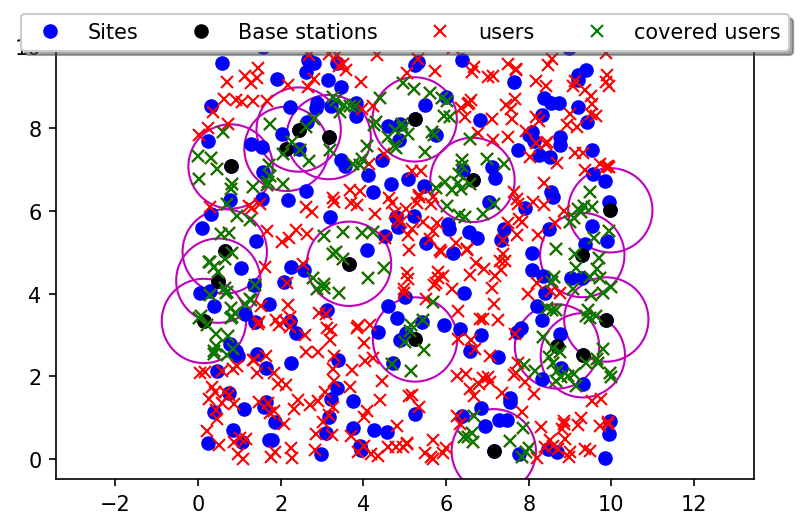

In [5]:
sites = init_sites()
users = ue()
index_bs = index_config()
plot_map(sites, index_bs, users)

We ran the algorithm for 500 iterations, and below one can notice that the number of covered users has increased as expected.

**3) 4)**

**$\beta = 0.9$**

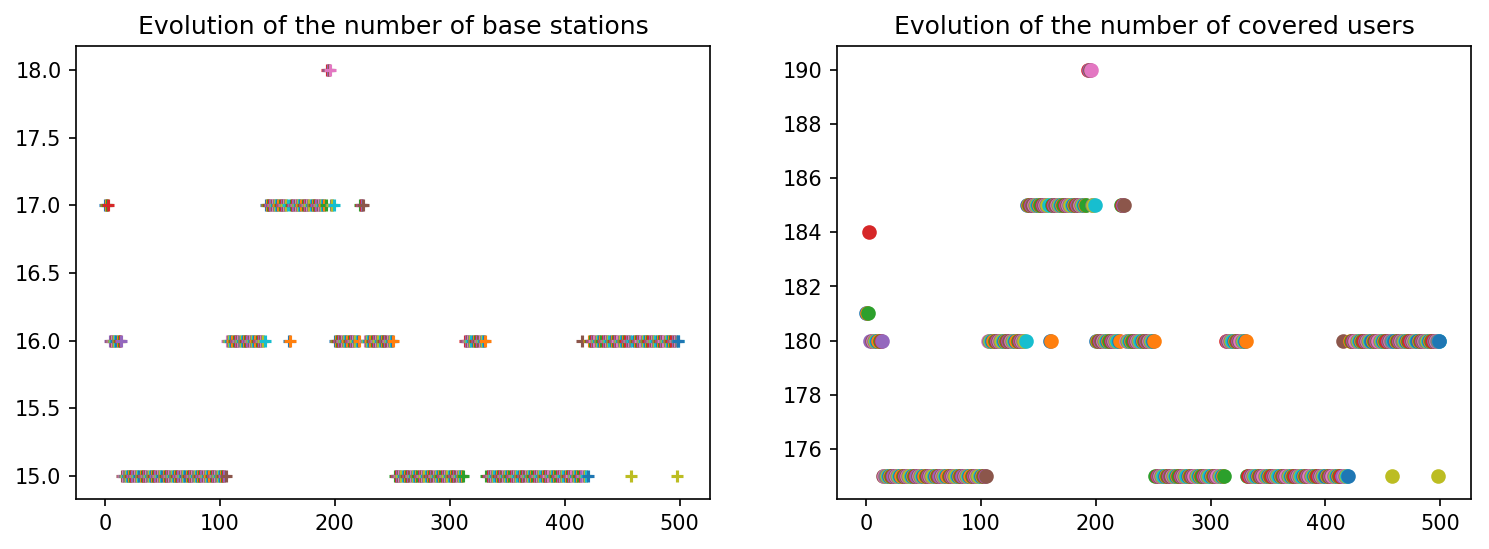

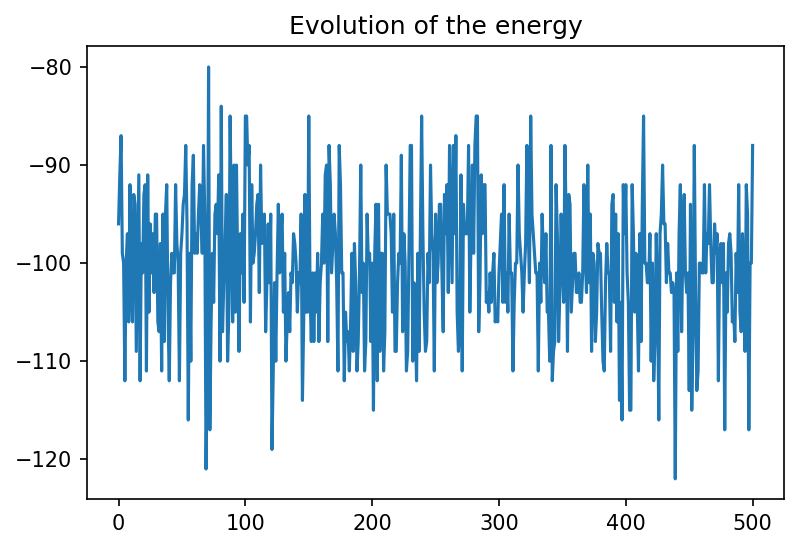

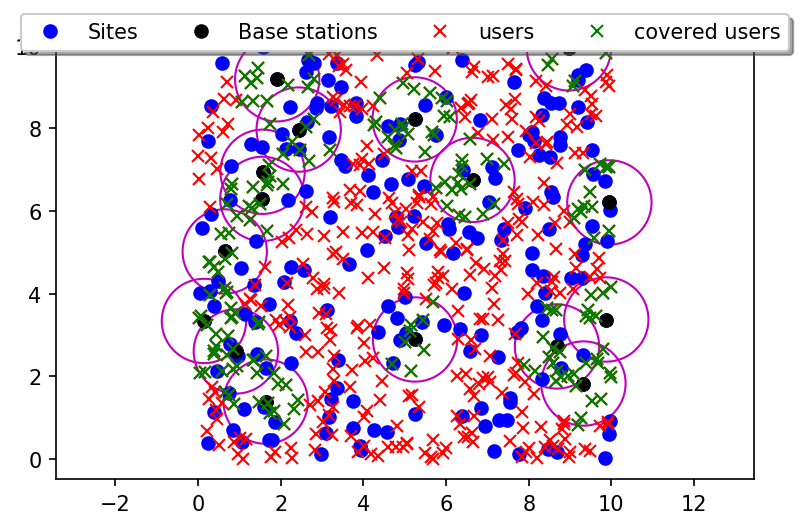

In [19]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.9)
plot_map(sites, opt_index_bs, users)

**$\beta = 0.98$**

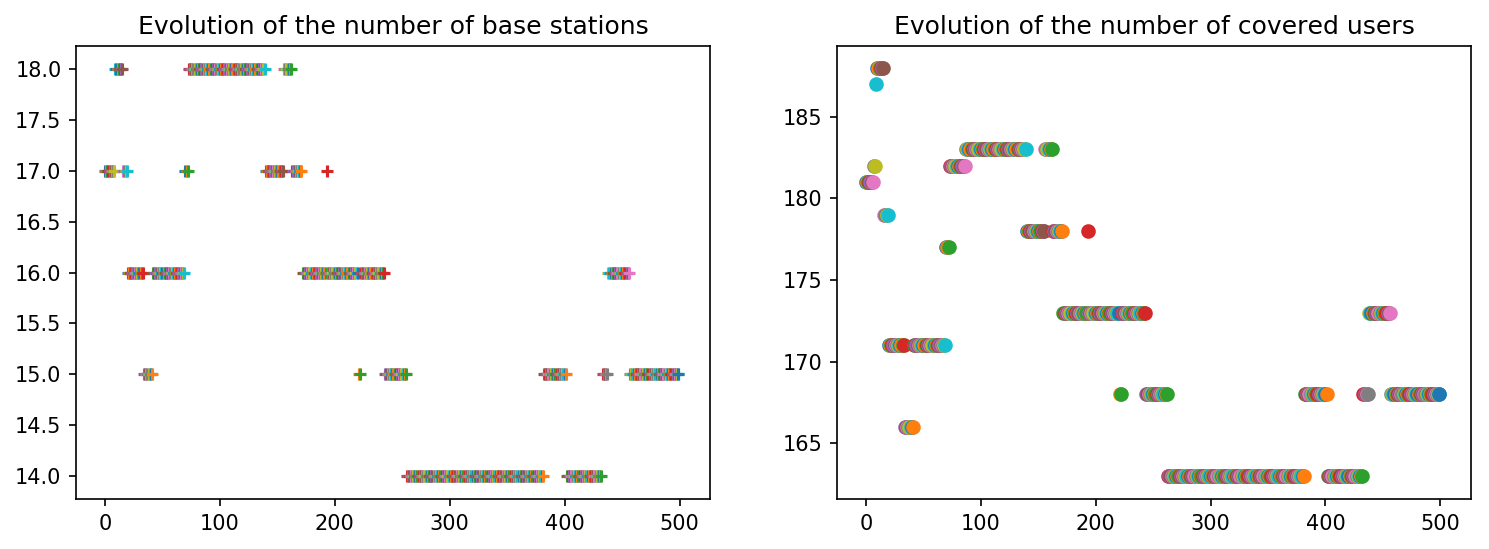

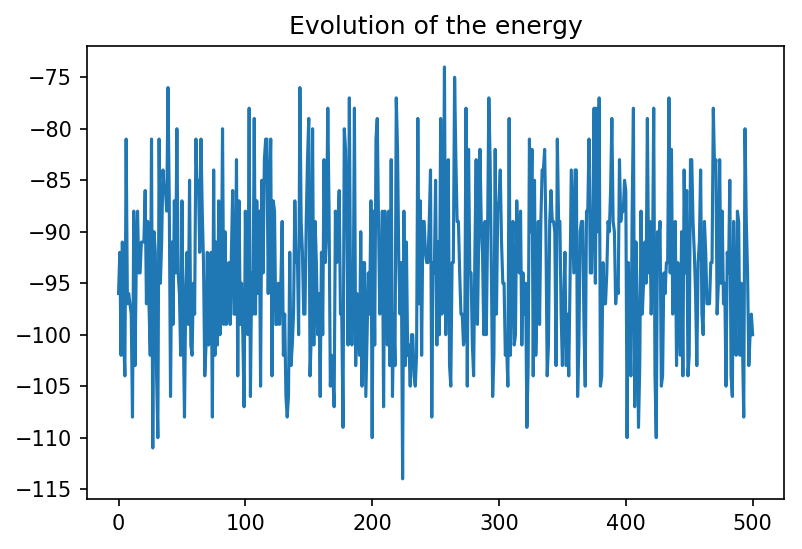

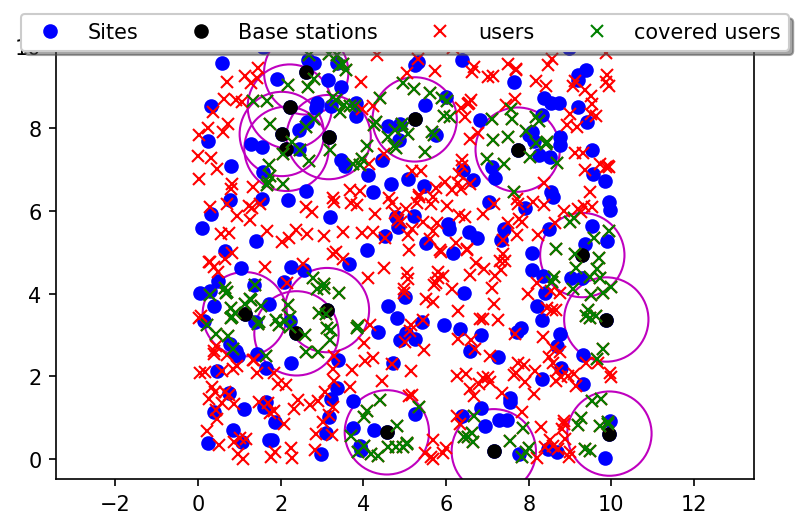

In [20]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.98)
plot_map(sites, opt_index_bs, users)

Here we have the map with an optimized placement of base stations. The situation is better. Indeed, when we look at the expression and the trend of the curves, it is better for the operator to have fewer base stations while covering the most possible users. Here with $\beta$ higher, it seems that there is even less base stations, but the algorithm manages to limit the decrease of the number of users covered. Here we are sure that the operator gains some profit from that operation even though it is to the detriment of some users.


**$\beta = 0.85$**

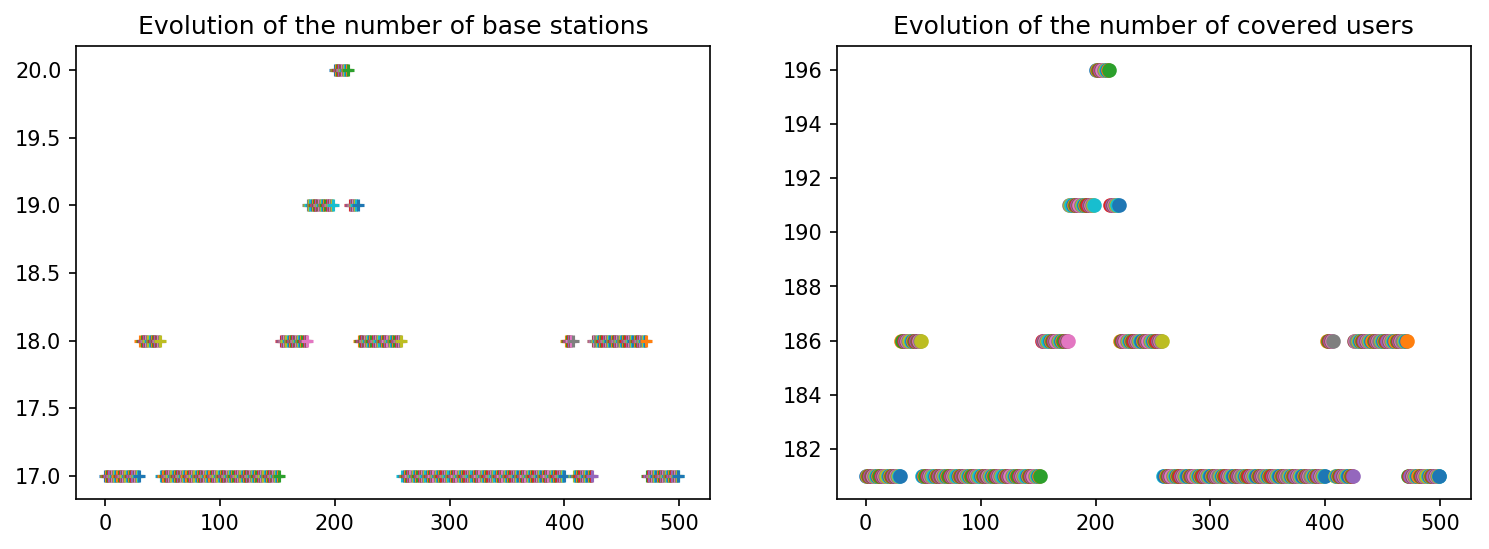

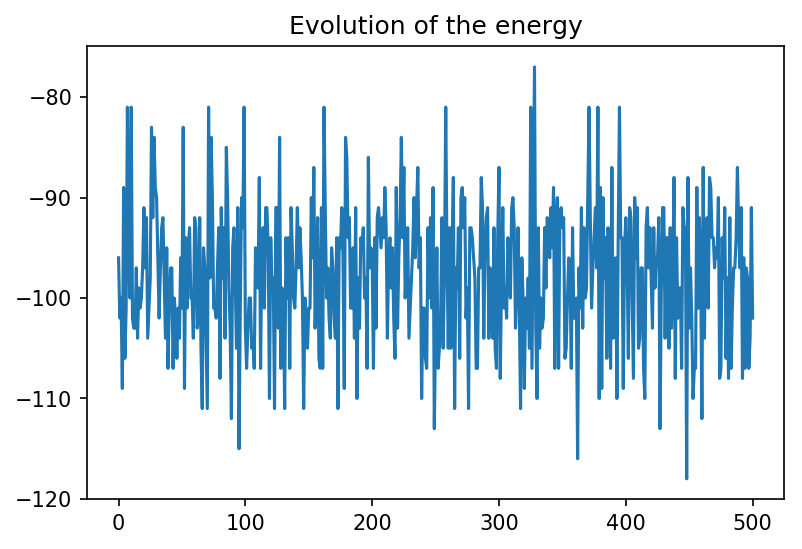

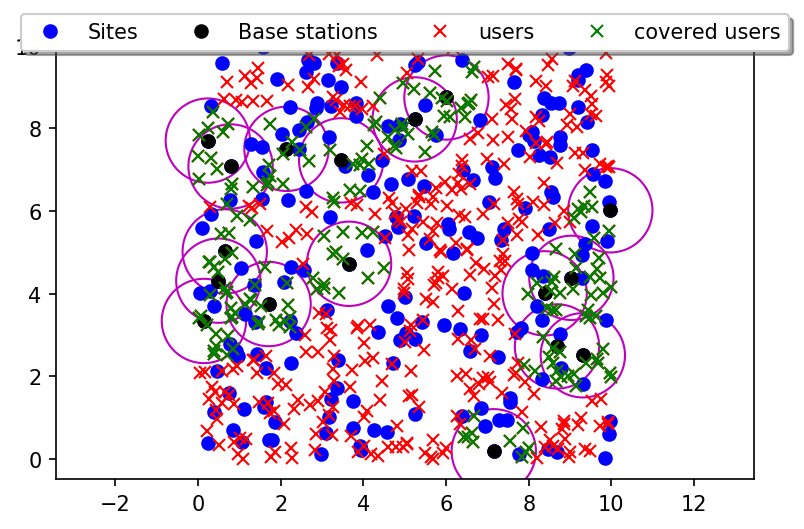

In [21]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.85)
plot_map(sites, opt_index_bs, users)

Here it is clear that we lose too much users, but the graphs show that towards step $200$ the algorithm did get a better revenue by covering way more user. So the result at the end of the iterations is a little disappointing, but globally SA algorithm optimizes but there is randomness to consider.

### 2.b) Analysis <a name="paragraph2b"></a>

The maps above show that there are more base stations covering the the boundaries of the square area than in the previous map after the optimization. So the SA algorithm realizes the optimization in a natural way. It tries to cover with base stations further enough to cover efficiently. 

The SA algorithm needs to tune the hyperparameters $T_0$ and $\beta$. It seems better to have $\beta$ higher than $0.9$, but it is hard with the previous simulations to explain the influence of $T_0$. Also, because there is randomnesss in the algorithm, there is not assurance that the output configuration will be better. The evolution of the energy shows that we will not get close enough to optimal values in finite time. On the contrary of gradient descent method, the energy does not decrease every step.

It can be interesting to increase the number of iterations to see how well the BSs placement can be optimized, but it seems for our applications that one can set a bar for the best possible increase of revenue. If at some steps it does overpass a threshold, the program will stop and we will see the output map. Indeed the algorith is powerful because it converges towards an optimal value whereas gradient descent methods may not. However it takes time, because of the Markov model, to change the configuration. It is better to have a target which is not necessarily the optimum so to shorten the time of computation.



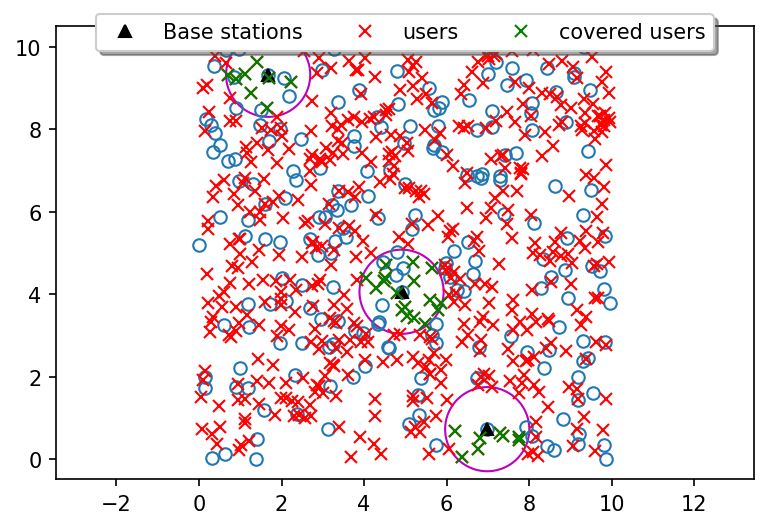

In [24]:
sites = init_sites()
users = ue()
index_bs = index_config()
plot_map(sites, index_bs, users)

3


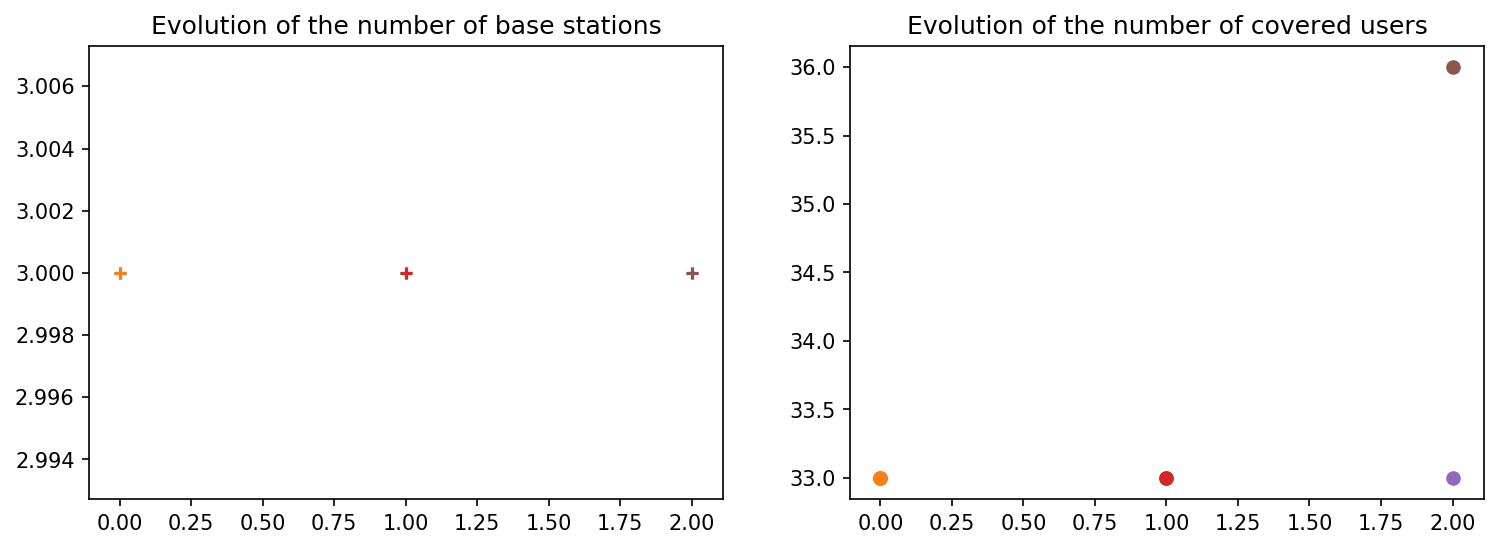

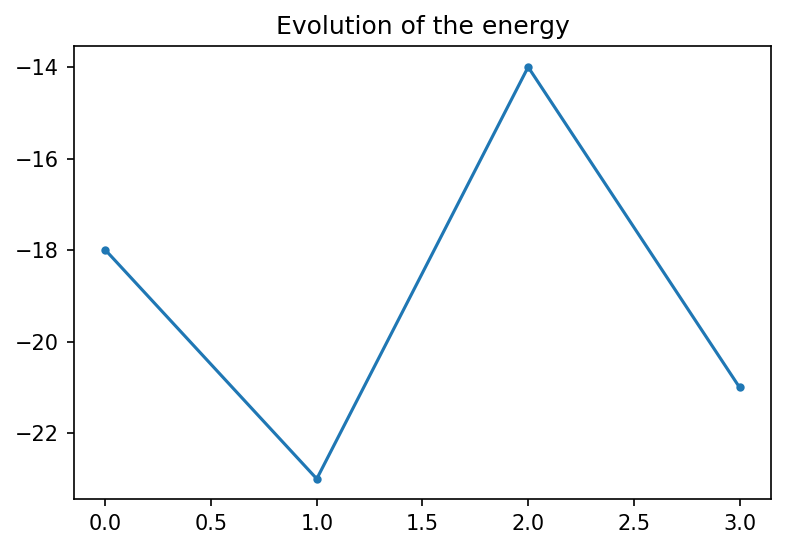

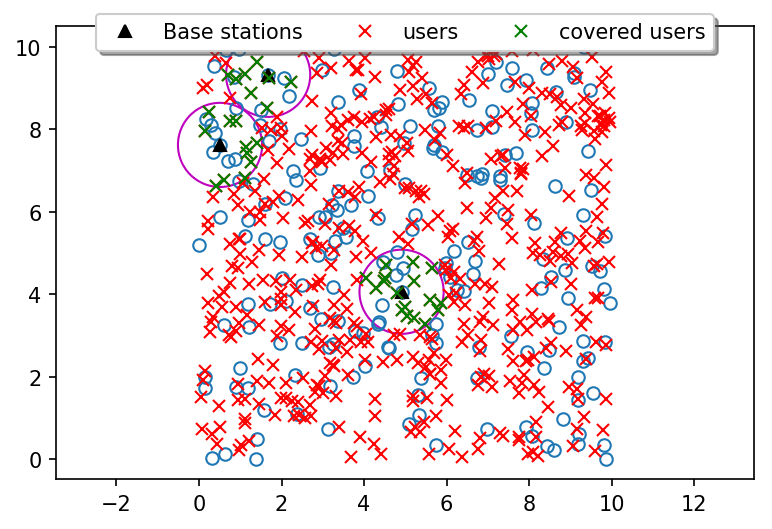

In [29]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.85, thres=-20)
plot_map(sites, opt_index_bs, users)

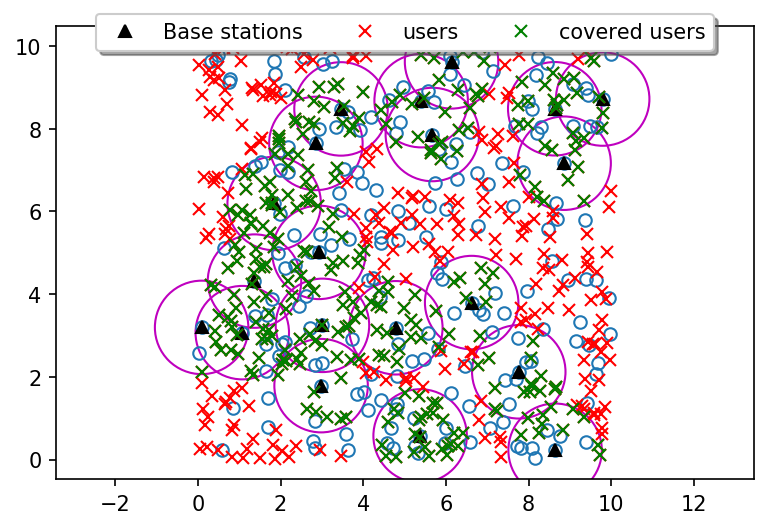

In [34]:
sites = init_sites()
users = ue()
index_bs = index_config()
plot_map(sites, index_bs, users)

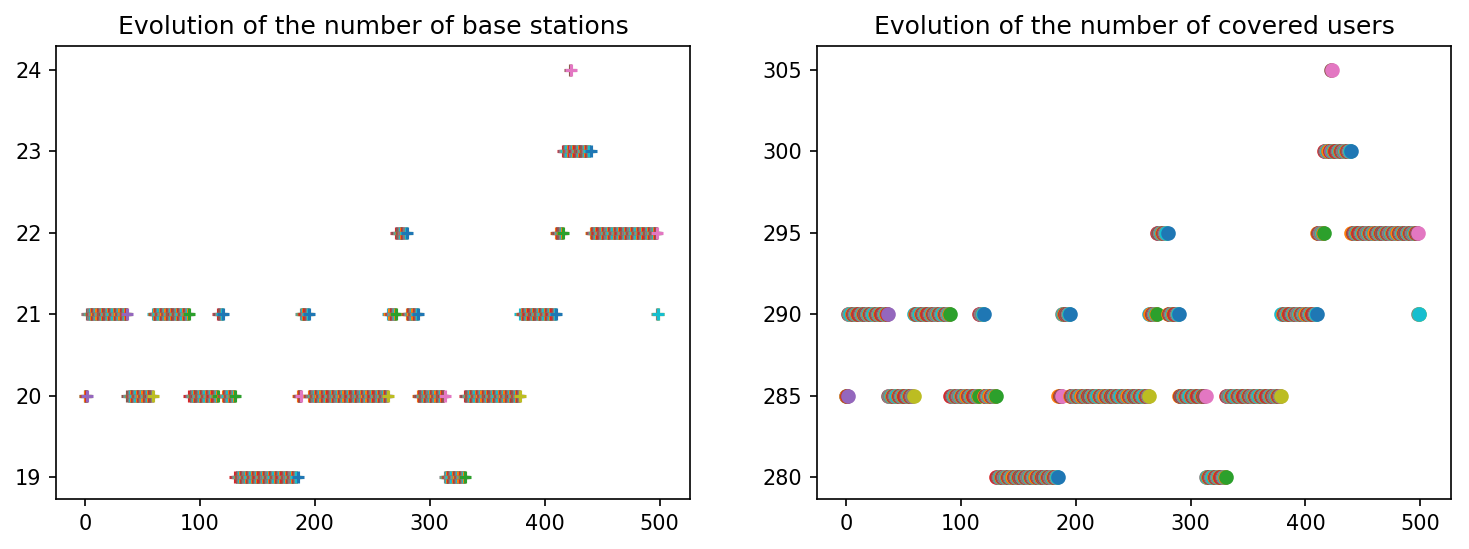

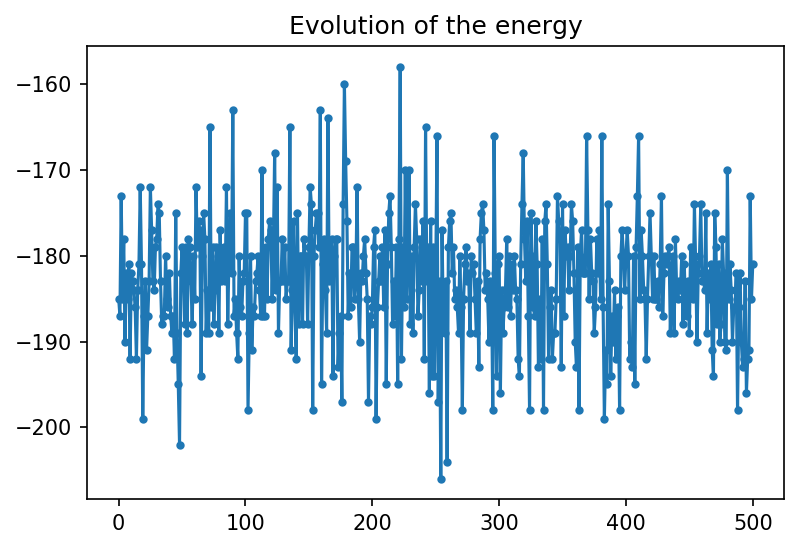

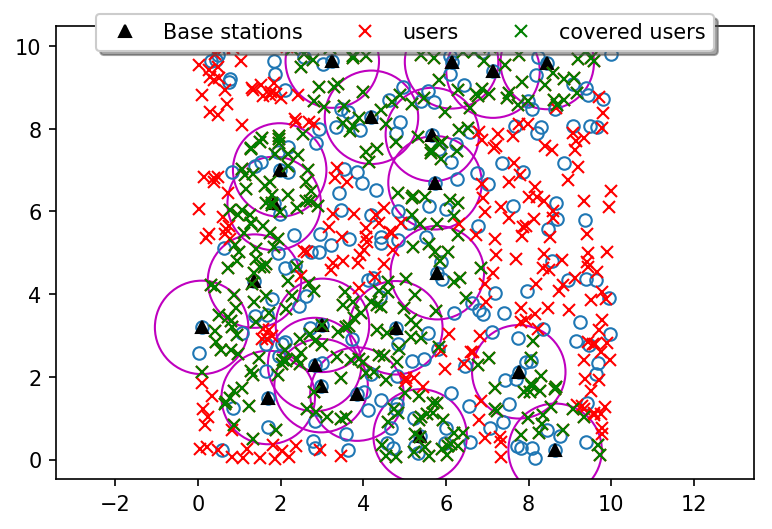

In [36]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.85, thres=-200)
plot_map(sites, opt_index_bs, users)

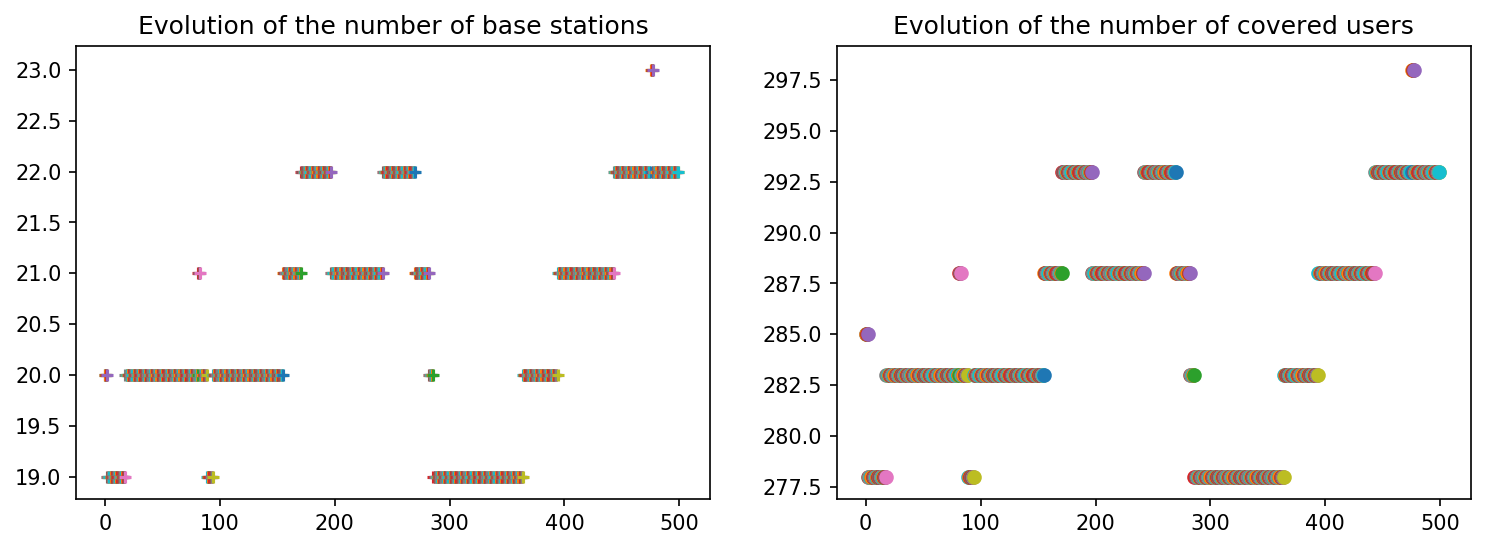

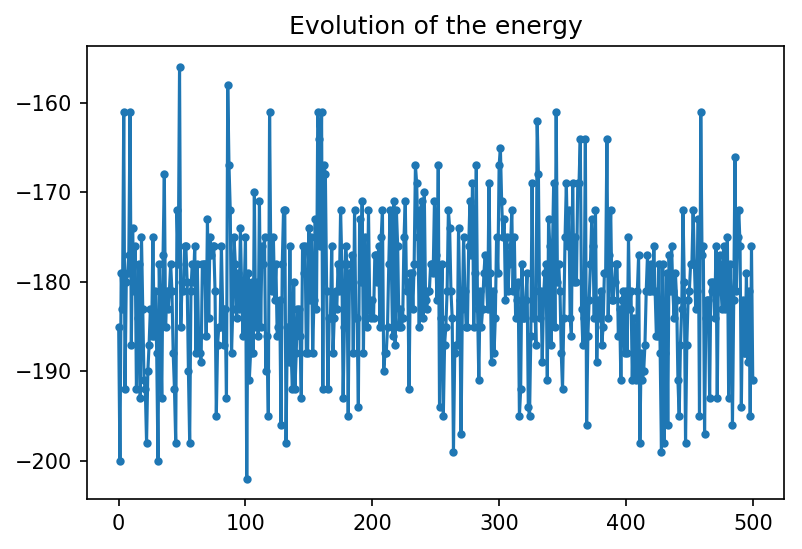

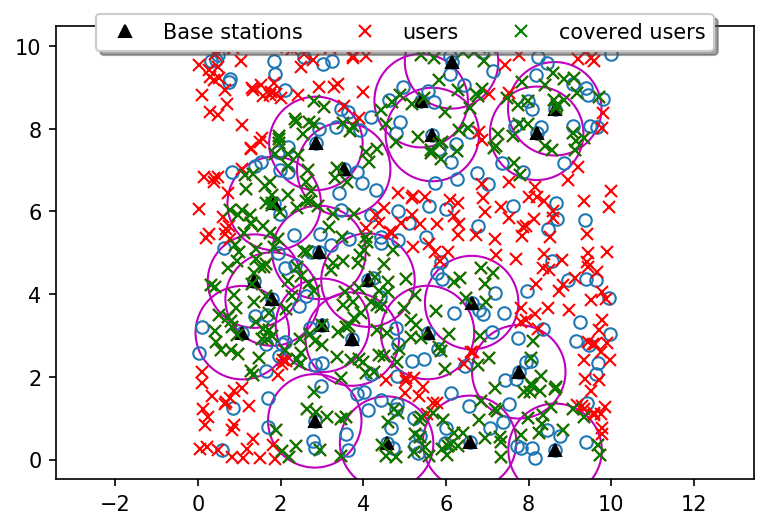

In [37]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.85, thres=-190)
plot_map(sites, opt_index_bs, users)

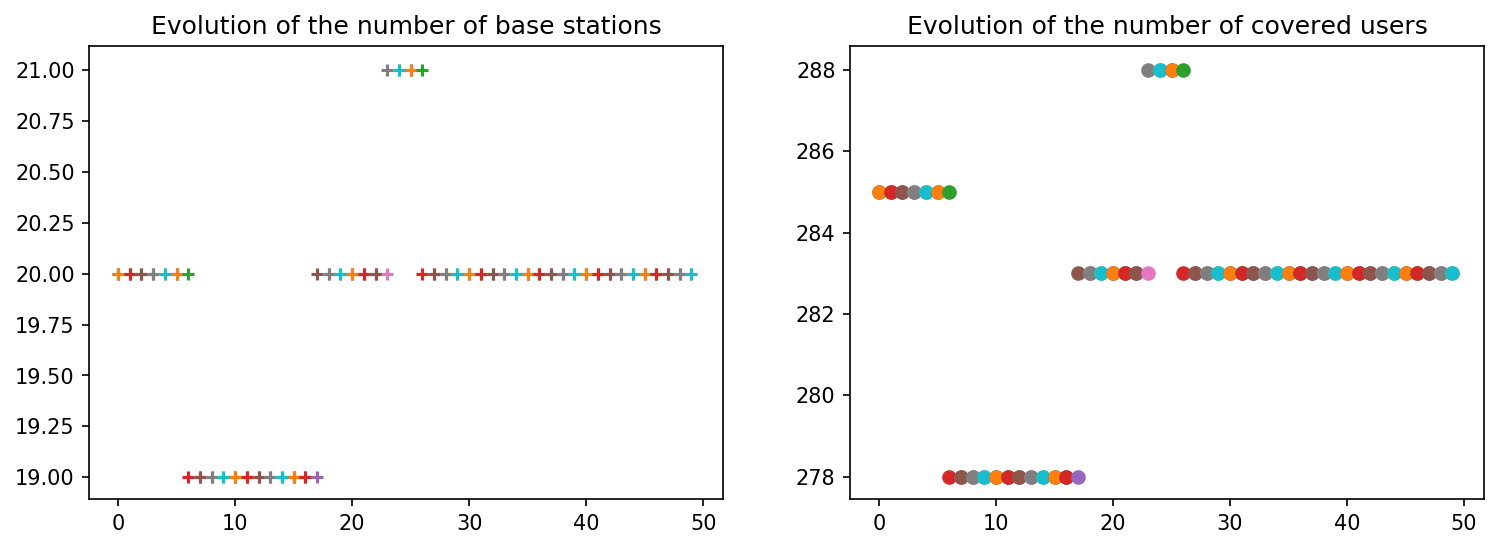

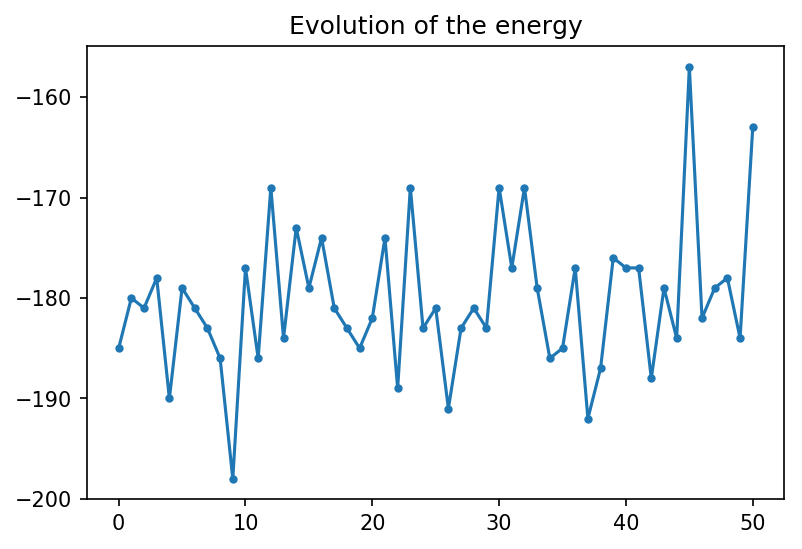

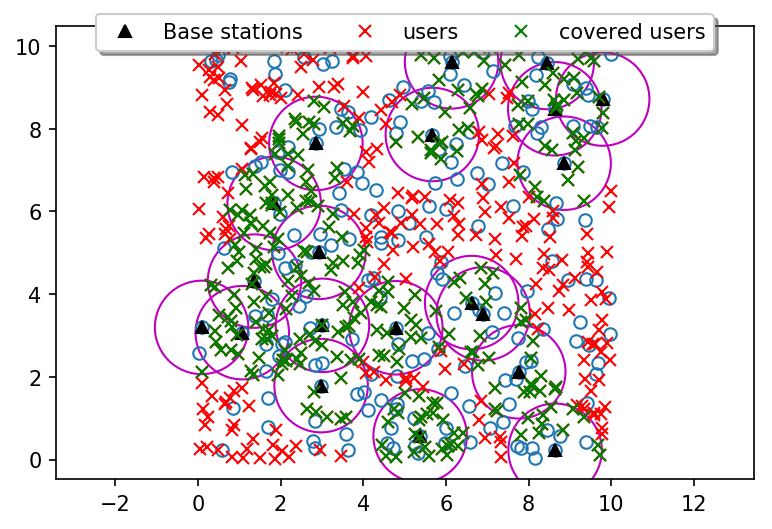

In [42]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.85, thres=-185)
plot_map(sites, opt_index_bs, users)

$\beta = 0.98$

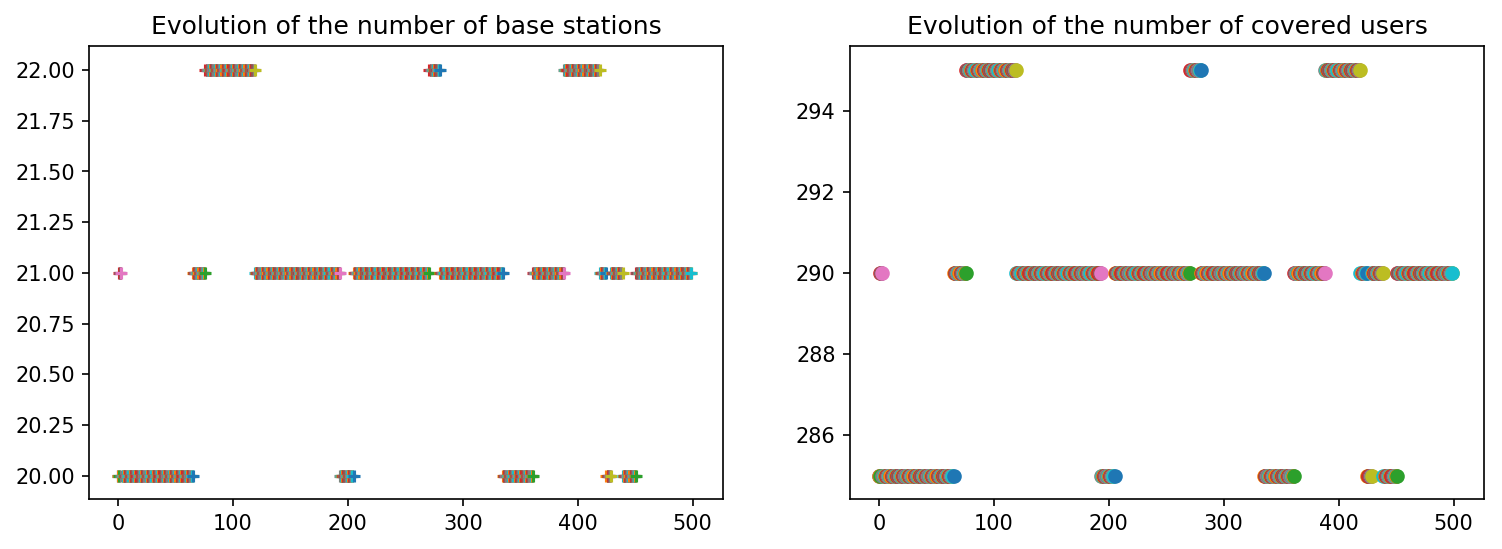

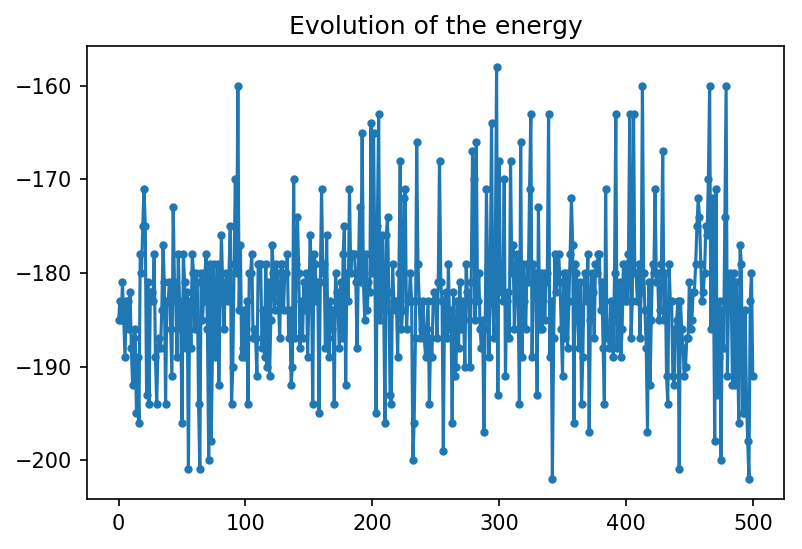

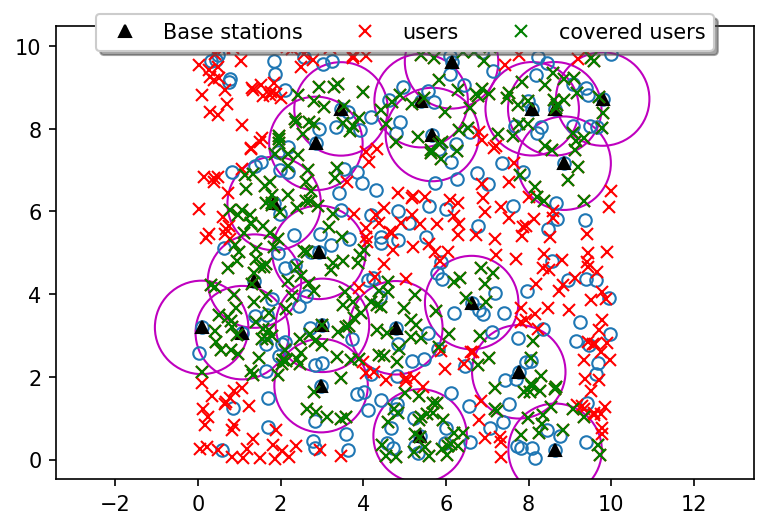

In [39]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.95, thres=-185)
plot_map(sites, opt_index_bs, users)

9


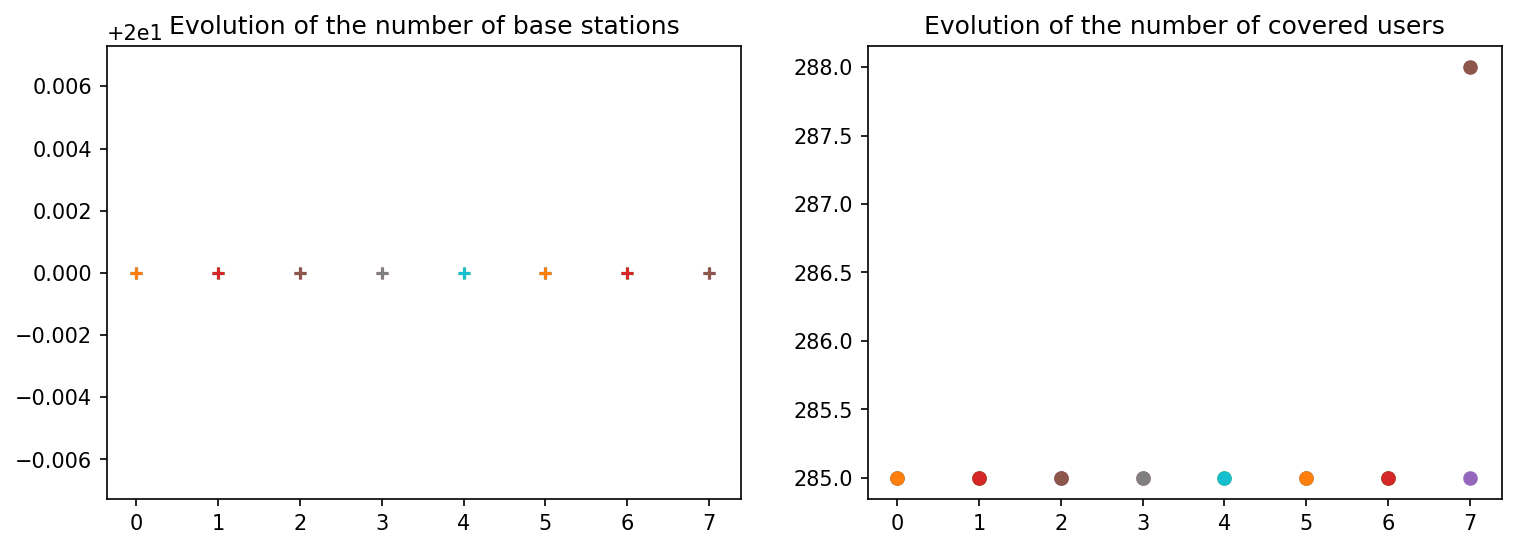

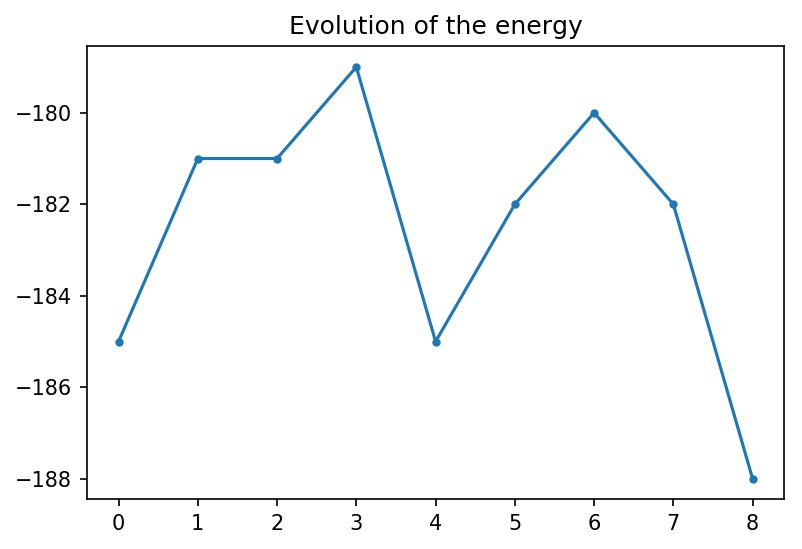

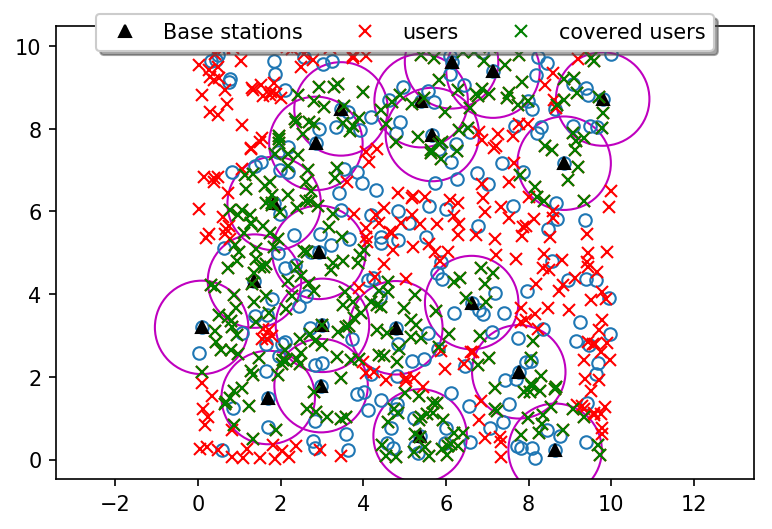

In [41]:
opt_index_bs = SA(sites, index_bs, users, 2, 0.95, thres=-185)
plot_map(sites, opt_index_bs, users)

From those experiences, by establishing a threshold or descreasing the number of iterations, the energy decreases as wanted, so the revenue increases. But it seems that it does not increase much. The algorithm tends to favor the increase of users covered even though it does increase the number of base stations. So it does the optimization in the expected way on many of my experiments. 

## 3. Conclusion <a name="paragraph3"></a>

To put it in a nutshell, SA algorithm seems to be a handy algorithm to proceed the optmization of placement of base station for the operator. It stems from the Metropolis-Hastings method which converges. The randomness allows not to fall in local minima on the contrary of gradient descent method when applied to discrete optimization.  

**5)** There is room for improvements in the modelization.

* We generated users and sites using uniform law. As we have seen in the course RIO208, one can modelize both as Poisson process respectively with intensity $\lambda_u = 50$ and $\lambda_s = 1$. Those processes may better cover the square area.

* Here the cost function was surely an approximation of the true energy. One can take into account the fact that the cost of installing a base station can vary from place to place. 

* The users may not take benefit from the same services, so in the optimization the ones using data may be more prone to be covered by neighborhoods in the algorithm.

* We use a simplified algorithm for finding the neighborhood in order to minimize the time of computation but we can think of adding a site which is close to the configuration. It seems more natural and at the same time we may loose less users in the process. Yet, it might slow down the algorithm.

* When we have the sites, maybe we should not choose base stations randomly. It would be better to make a grid of the area and force the base stations to be close to the center of each box of the grid. Our modelization does not prevent base stations to touch each other on the map. It is studied in RIO208, but one can think of unify both views for modelization.

